<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 
</p>    
<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.


**Le problème posé :**


*Stack Overflow est un site célèbre de question-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.*

*Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.*

 
    
<p>
La requête SQL suivante a permis de récupérer :

* les données du jeux d'entrainement:     

    ``SELECT Id, PostTypeId, Body, Title, Tags from Posts where Id<200000 and PostTypeId=1;``
    

* les données du jeux de test :

    ``SELECT Id, PostTypeId, Body, Title, Tags from Posts where Id>=200000 and Id<300000 and PostTypeId=1;``
    
</p>
<p>



In [33]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import p6_util
import p6_util_plot

# <font color='blus'>1. Paramaters</font>

In [2]:
#-------------------------------------------------------------------------------
# Apply or not stemming process over sentences
#-------------------------------------------------------------------------------
is_stemming=False

## <font color='blus'>2. SOF Tags analysis</font>

In [10]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)

In [11]:
df_sof_tags.shape, df_sof_tags.columns

((50000, 2), Index(['TagName', 'Count'], dtype='object'))

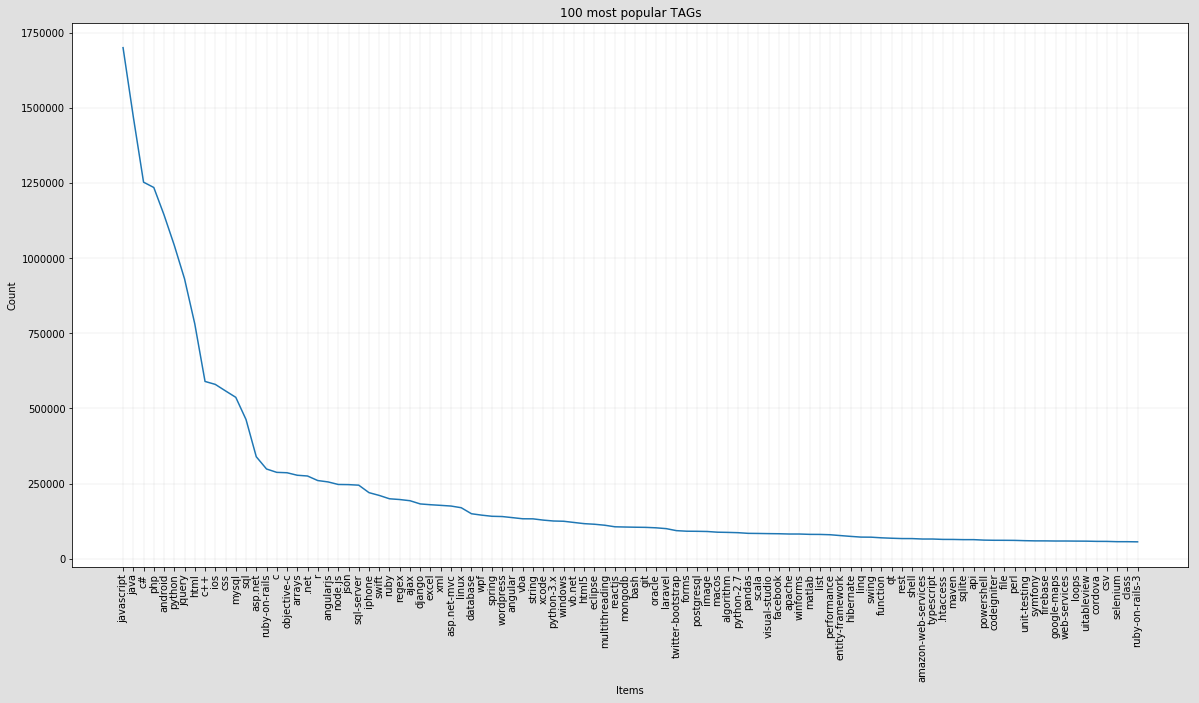

In [17]:
import p6_util_plot

item_count=100
title = str(item_count)+" most popular TAGs"
p6_util_plot.ser_item_occurency_plot(df_sof_tags.TagName,df_sof_tags.Count,item_count, title)

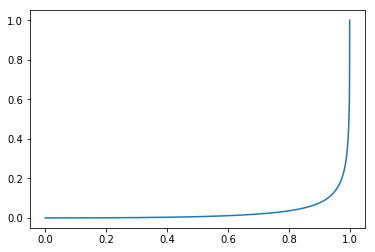

0.9433176218791084

In [17]:
import numpy as np

dep =df_sof_tags.Count.values

import matplotlib.pyplot as plt

lorenz = np.cumsum(np.sort(df_sof_tags.Count)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post')
plt.show()

# Pour l'indice de GINI
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
gini = 2*S
gini

---------------------------Count----------------------------
Moyenne: 948.7015
Mediane: 35.0
Modes: 0    1
dtype: int64
Variance: 311074324.89710766
Ecart:17637.299251787605


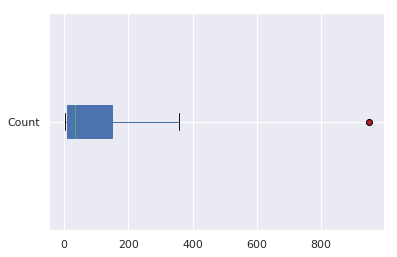

In [9]:
import p5_util_plot
import p3_util_plot
p3_util_plot.df_boxplot_list_display(df_sof_tags, ['Count'], show_outliers=False )


/home/bangui/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



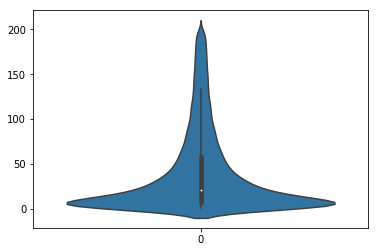

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.violinplot( data=df_sof_tags[df_sof_tags.Count<200].Count)

In [19]:
# Chapiro/Wilk test
x = df_sof_tags['Count']

shapiro_results = scipy.stats.shapiro(x[:4000])
print("Shapiro test : Statistics= {} / p-value= {}".format(shapiro_results[0],shapiro_results[1] ))


ks_results = scipy.stats.kstest(x, cdf='norm')
print("Kolmogorov/Smirnov test : Statistics= {} / p-value= {}".format(ks_results[0],ks_results[1] ))


# P-value is read as 0.0 (meaning it is "practically" 0 given the decimal accuracy of the test) then we have strong evidence to not reject the null-hypothesis



Shapiro test : Statistics= 0.01359790563583374 / p-value= 0.0
Kolmogorov/Smirnov test : Statistics= 0.9386498680518208 / p-value= 0.0


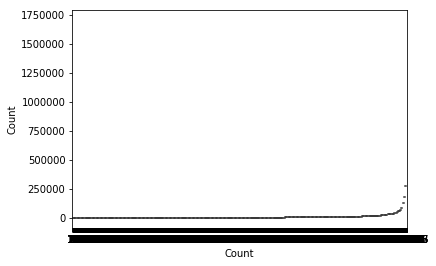

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.violinplot(y=x, x='Count', 
                       data=df_sof_tags, 
                       width=0.8,
                       inner='quartile',
                       palette="colorblind")

# <font color='blus'>3. Data analysis</font>

In [1]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
df_sof_train=pd.read_csv(file_name)

In [2]:
print(df_sof_train.columns)

Index(['Id', 'PostTypeId', 'Body', 'Title', 'Tags'], dtype='object')


## <font color='blus'>3.1. Train data-set processing</font>

**Merge Body and Title columns**

``Title`` elements are regarded as synthetisis of ``Body`` elements.

Merging ``Title`` with ``Body`` enreach ``Body`` contents with more relevant informations.

In [3]:
df_sof_train['Body']=df_sof_train['Body']+df_sof_train['Title']

**Dataset processing**

Expressions between markers ``code`` and ``/code`` are all removed.

Such expressions are computer language specifics, different as english language. It is considered as having  no semantic value for english language.

In [4]:
df_sof_train.columns

Index(['Id', 'PostTypeId', 'Body', 'Title', 'Tags'], dtype='object')

In [7]:
import p6_util
ser_sof_train = p6_util.p6_df_standardization(df_sof_train.Body, is_lem=False)


Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove non alpha-numeric words from sentences...

Remove verbs from sentences...

Removing stopwords...


In [8]:
import p5_util
file_name='./data/ser_sof_train.dump'
p5_util.object_dump(ser_sof_train, file_name)

## <font color='blus'>3.2. Posts analysis</font>

**Cleaned dataset is loaded from dumped file**

In [20]:
import p5_util
file_name='./data/ser_sof_train.dump'
ser_sof_train = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/ser_sof_train.dump


### <font color='blus'>3.2.1. Words occurence computation</font>

Series ``ser_sof_train`` is converted into a dictionary in order to feed ``compute_frequency_sentence`` function.

In [21]:
ser_sof_train[0]
ser_sof_train.shape
len(dict_body_train.values())

NameError: name 'dict_body_train' is not defined

In [22]:
import nltk

list_content = list()
token_mode = 'nltk'
if token_mode == 'split' :
    for root_name in dict_body_train.keys():
        content= dict_body_train[root_name]
        tokenized_content = content.split(' ')
        list_content += tokenized_content
elif token_mode == 'nltk' :
    for root_name in dict_body_train.keys():
        content= dict_body_train[root_name]
        tokenized_content = nltk.word_tokenize(content)
        list_content += tokenized_content
else :
    print("*** ERROR : unknown tokenization mode= "+str(token_mode))
    #return None

freq_content = nltk.FreqDist(list_content)

#return freq_content

NameError: name 'dict_body_train' is not defined

In [23]:
import p6_util
dict_body_train = ser_sof_train.to_dict()
freq_body_train = p6_util.compute_frequency_sentence(dict_body_train, token_mode='nltk')

Transform freq_body_train into a dataframe in order to feed function `p6_util_plot.ser_item_occurency_plot`.

**Dictionary is ordered and converted into pandas dataframe.**

In [24]:
import pandas as pd

dict_word = dict()
dict_count = dict()
index =0
for tuple_item in freq_body_train.items():
    dict_word[index] = tuple_item[0]
    dict_count[index] = tuple_item[1]
    index += 1

df_word = pd.DataFrame.from_dict( dict_word, orient='index')
df_count = pd.DataFrame.from_dict( dict_count, orient='index')

df_word_count = pd.DataFrame({'Name':df_word[0],"Count":df_count[0]})


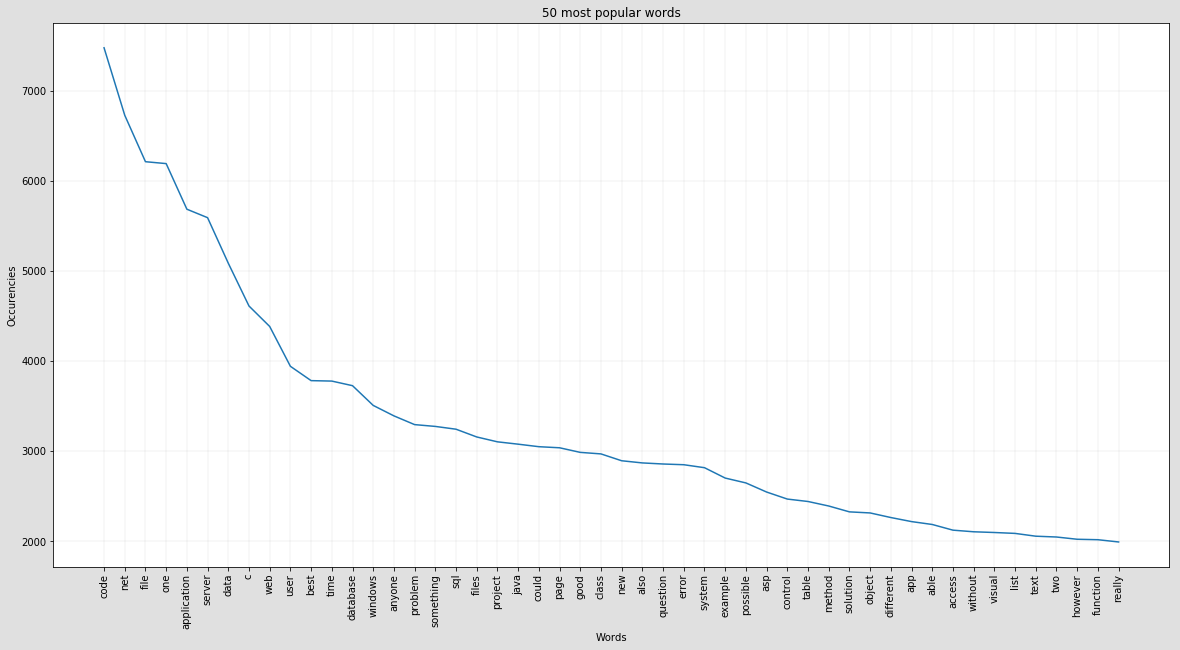

In [25]:
import p6_util_plot

item_count=50
title = str(item_count)+" most popular words"
p6_util_plot.ser_item_occurency_plot(df_word_count.Name,df_word_count.Count\
                                     ,item_count, title, p_reverse=True\
                                     , p_x_title="Words", p_y_title="Occurencies")

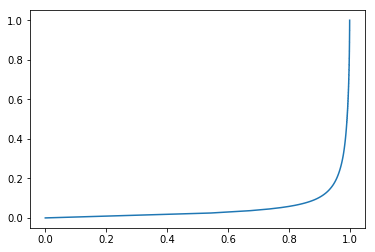

0.9034599165448454

In [27]:
import numpy as np

dep =df_word_count.Count.values

import matplotlib.pyplot as plt

lorenz = np.cumsum(np.sort(df_word_count.Count)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post')
plt.show()

# Pour l'indice de GINI
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
gini = 2*S
gini

In [19]:
import p6_util_plot
p6_util_plot.display_word_cloud(freq_body_train)

NameError: name 'freq_body_train' is not defined

<Figure size 720x720 with 0 Axes>

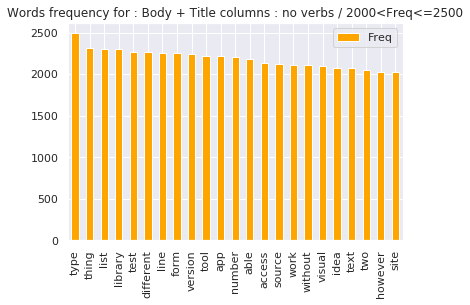

In [29]:
#from wordcloud import WordCloud, STOPWORDS 
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="2000<Freq<=2500")

<Figure size 720x720 with 0 Axes>

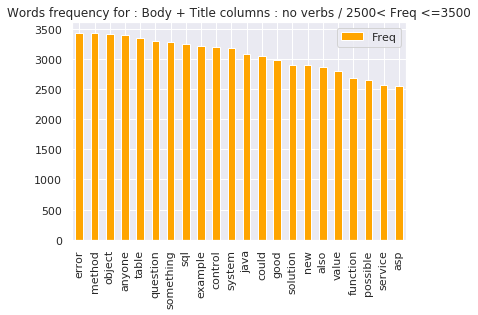

In [30]:
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="2500< Freq <=3500")

<Figure size 720x720 with 0 Axes>

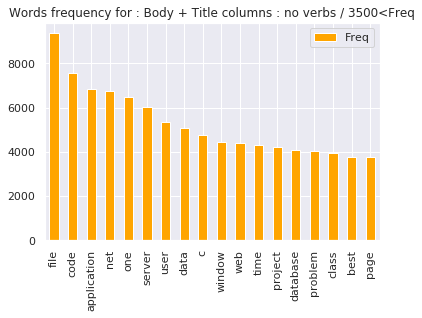

In [31]:
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="3500<Freq")

## <font color='blus'>3.3. Title analysis</font>

**<font color='blue'>Loading SOF TAGs as a referenced list</font>**

In [1]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
print(df_sof_tags.shape)
list_sof_tag = df_sof_tags.TagName.tolist( )

(50000, 2)


**<font color='blue'>Loading Title from Posts<font>**

In [28]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
ser_sof_title=pd.read_csv(file_name)['Title']
ser_sof_title.shape

(24604,)

**<font color='blue'>Titles processing</font>**

In [29]:
import p6_util
ser_title_train = p6_util.p6_df_standardization(ser_sof_title)


Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove non alpha-numeric words from sentences...

Remove verbs from sentences...

Removing stopwords...

Lemmatization ...


**<font color='blue'>Titles frequencies processing and plot</font>**

In [30]:
import p6_util
import pandas as pd

dict_title_train = ser_title_train.to_dict()
freq_title_train = p6_util.compute_frequency_sentence(dict_title_train, token_mode='nltk')

dict_word = dict()
dict_count = dict()
index =0
for tuple_item in freq_title_train.items():
    dict_word[index] = tuple_item[0]
    dict_count[index] = tuple_item[1]
    index += 1

df_word = pd.DataFrame.from_dict( dict_word, orient='index')
df_count = pd.DataFrame.from_dict( dict_count, orient='index')

df_word_count = pd.DataFrame({'Name':df_word[0],"Count":df_count[0]})


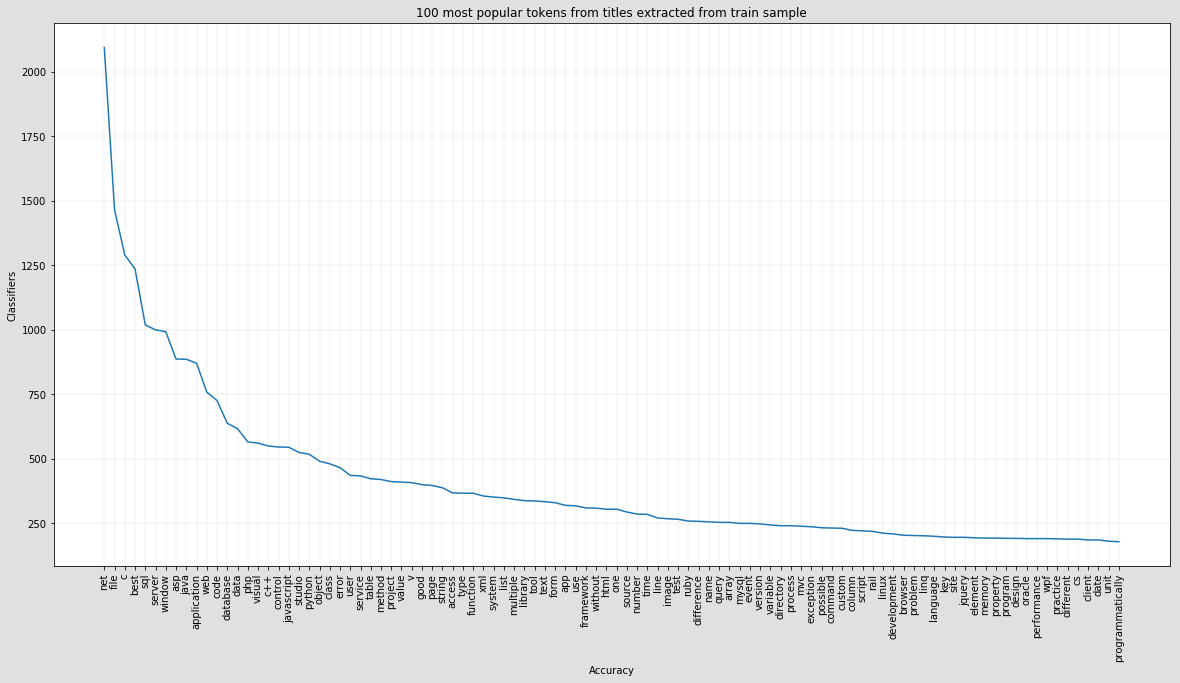

In [31]:
import p6_util_plot

item_count=100
title = str(item_count)+" most popular tokens from titles extracted from train sample"
p6_util_plot.ser_item_occurency_plot(df_word_count.Name,df_word_count.Count,item_count, title)

**Statistics of Titles tokens versus SOF TAGs**

In [32]:
intersection_count = len(set(list_sof_tag).intersection(df_word_count.Name.tolist()))
reftags_count = len(list_sof_tag)
print("Percentage train title tokens / SOF Tags = {0:1.2F}".format(100*intersection_count/reftags_count))
print("Percentage train title tokens issued from SOF Tags = {0:1.2F}".format(100*intersection_count/len(df_word_count.Name.tolist())))

NameError: name 'list_sof_tag' is not defined

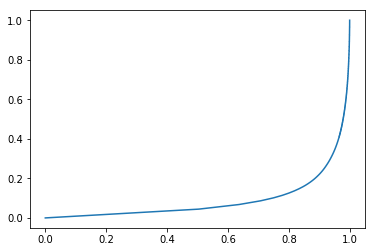

0.8209551428572897

In [33]:
import numpy as np

dep =df_word_count.Count.values

import matplotlib.pyplot as plt

lorenz = np.cumsum(np.sort(df_word_count.Count)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post')
plt.show()

# Pour l'indice de GINI
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
gini = 2*S
gini

## <font color='blus'>3.4. TAGs analysis from train sample</font>

**Loading SOF TAGs as a referenced list**

In [44]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
print(df_sof_tags.shape)
list_sof_tag = df_sof_tags.TagName.tolist( )

(50000, 2)


**Loading TAGs from Posts**

In [45]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
ser_train_body_tags=pd.read_csv(file_name).Tags.copy()
ser_train_body_tags.shape

(24604,)

In [3]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"

df_train_body_tags=pd.read_csv(file_name)
df_train_body_tags.shape

(24604, 5)

**TAGs are tokenized**

In [48]:
import p6_util

#csr_matrix_encoded_train_tag, list_ref_train_tag = p6_util.p6_encode_ser_tag_2_csrmatrix(ser_sof_train_tags, leading_marker='<', trailing_marker='>')
ser_train_body_tags = ser_train_body_tags.apply(p6_util.clean_marker_text, leading_marker='<'\
    , trailing_marker='>')

In [ ]:
ser_train_body_tags.sample()

**List of TAGs issued from tokenization is extracted**

In [51]:
import p6_util
list_ref_train_body_tags = p6_util.p6_get_list_all_tag(ser_train_body_tags)

**Encoding TAGs issued from train sample in order to compute number of tags**

In [57]:
import p6_util
csr_matrix_encoded_tag \
    = p6_util.p6_encode_target_in_csr_matrix(list_ref_train_body_tags, ser_train_body_tags.tolist())

In [ ]:
csr_matrix_encoded_tag.shape

**TAGs frequencies processing and plot**

In [12]:
import p6_util
import pandas as pd

dict_train_body_tags = ser_train_body_tags.to_dict()

#freq_train_body_tags = p6_util.compute_frequency_sentence(dict_train_body_tags)

dict_train_body_sentence_tags = {key:" ".join(value) for key, value in dict_train_body_tags.items() }

freq_train_body_sentence_tags = p6_util.compute_frequency_sentence(dict_train_body_sentence_tags, token_mode='nltk')


dict_word = dict()
dict_count = dict()
index =0
for tuple_item in freq_train_body_sentence_tags.items():
    dict_word[index] = tuple_item[0]
    dict_count[index] = tuple_item[1]
    index += 1

df_word = pd.DataFrame.from_dict( dict_word, orient='index')
df_count = pd.DataFrame.from_dict( dict_count, orient='index')

df_tag_count = pd.DataFrame({'TagName':df_word[0],"TagCount":df_count[0]})


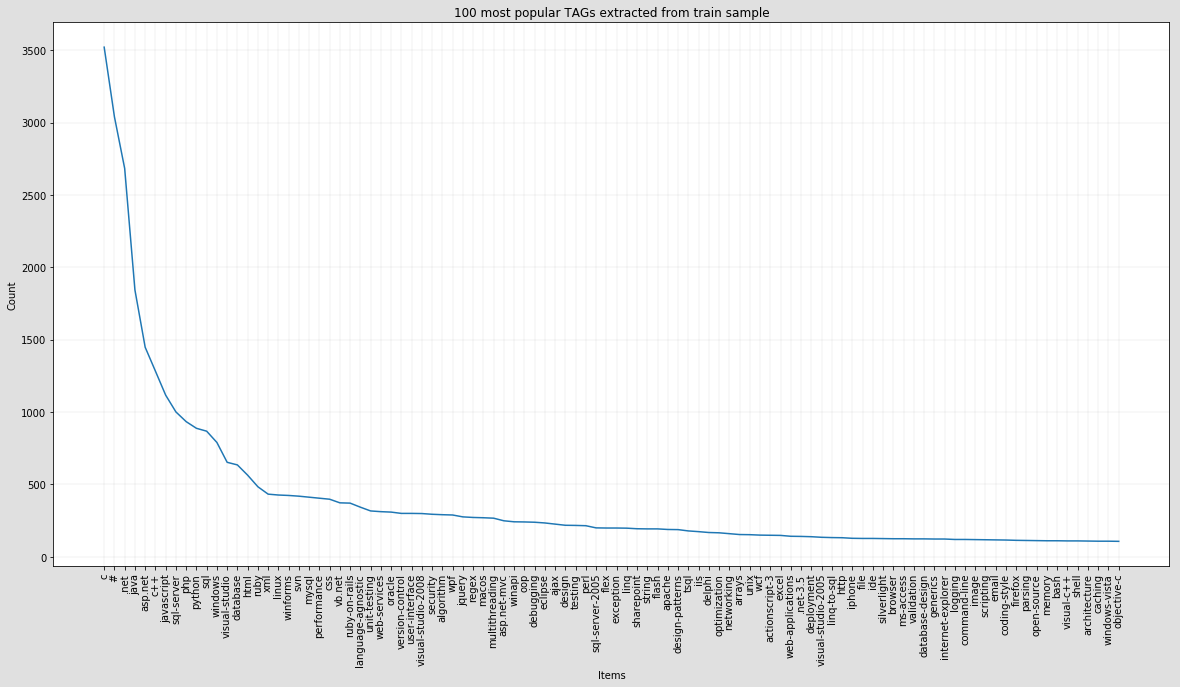

In [13]:
import p6_util_plot

item_count=100
title = str(item_count)+" most popular TAGs extracted from train sample"
p6_util_plot.ser_item_occurency_plot(df_tag_count.TagName,df_tag_count.TagCount,item_count, title)

**Statistics of Titles tokens versus SOF TAGs**

In [14]:
intersection_count = len(set(list_sof_tag).intersection(list_ref_train_body_tags))
reftags_count = len(list_sof_tag)
print("Percentage train TAGs / SOF Tags = {0:1.2F} %".format(100*intersection_count/reftags_count))
print("Percentage train TAGs issued from SOF Tags = {0:1.2F} %".format(100*intersection_count/len(list_ref_train_body_tags)))


Percentage train TAGs / SOF Tags = 12.02 %
Percentage train TAGs issued from SOF Tags = 93.38 %
